# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from model_tool import ToxModel, AttentionToxModel, compute_auc, load_maybe_score, postprocess_madlibs, postprocess_wiki_dataset
import model_bias_analysis
# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


HELLO from model_tool


In [2]:
%%time
from model_tool import AttentionToxModel
MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
random_models = [ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [ToxModel(name) for name in debias_model_names]

attention_model_names = ['cnn_attention_wiki_tox_v2_{}'.format(i) for i in xrange(100, 110)]
attention_models = [AttentionToxModel(name) for name in attention_model_names]

attention_debiased_model_names = ['cnn_attention_debias_tox_v2_{}'.format(i) for i in xrange(100, 110)]
attention_debiased_models = [AttentionToxModel(name) for name in attention_debiased_model_names]


Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_wiki_tox_v3_100
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_wiki_tox_v3_101
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [12

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_debias_tox_v3_102
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_debias_tox_v3_103
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes:

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_attention_debias_tox_v2_104
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: cnn_attention_debias_tox_v2_105
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 

In [3]:
all_model_families = [wiki_models, random_models, debias_models, attention_models, attention_debiased_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names, attention_model_names, attention_debiased_model_names]
#all_model_families = [attention_models, attention_debiased_models]
#all_model_families_names = [attention_model_names, attention_debiased_model_names]
print(all_model_families_names)

[['wiki_cnn_v3_100', 'wiki_cnn_v3_101', 'wiki_cnn_v3_102', 'wiki_cnn_v3_103', 'wiki_cnn_v3_104', 'wiki_cnn_v3_105', 'wiki_cnn_v3_106', 'wiki_cnn_v3_107', 'wiki_cnn_v3_108', 'wiki_cnn_v3_109'], ['wiki_debias_random_cnn_v3_100', 'wiki_debias_random_cnn_v3_101', 'wiki_debias_random_cnn_v3_102', 'wiki_debias_random_cnn_v3_103', 'wiki_debias_random_cnn_v3_104', 'wiki_debias_random_cnn_v3_105', 'wiki_debias_random_cnn_v3_106', 'wiki_debias_random_cnn_v3_107', 'wiki_debias_random_cnn_v3_108', 'wiki_debias_random_cnn_v3_109'], ['wiki_debias_cnn_v3_100', 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102', 'wiki_debias_cnn_v3_103', 'wiki_debias_cnn_v3_104', 'wiki_debias_cnn_v3_105', 'wiki_debias_cnn_v3_106', 'wiki_debias_cnn_v3_107', 'wiki_debias_cnn_v3_108', 'wiki_debias_cnn_v3_109'], ['cnn_attention_wiki_tox_v2_100', 'cnn_attention_wiki_tox_v2_101', 'cnn_attention_wiki_tox_v2_102', 'cnn_attention_wiki_tox_v2_103', 'cnn_attention_wiki_tox_v2_104', 'cnn_attention_wiki_tox_v2_105', 'cnn_attention

## Load datasets

In [4]:
all_models = wiki_models + random_models + debias_models + attention_models + attention_debiased_models
#all_models = attention_models

In [5]:
%%time


madlibs = load_maybe_score(
    all_models,
    orig_path='../eval_datasets/bias_madlibs_77k.csv',
    scored_path='../eval_datasets/bias_madlibs_77k_scored.csv',
    postprocess_fn=postprocess_madlibs)
print(madlibs.columns)

Using previously scored data: ../eval_datasets/bias_madlibs_77k_scored.csv
Index([u'Unnamed: 0', u'text', u'Template', u'label', u'wiki_cnn_v3_100',
       u'wiki_cnn_v3_101', u'wiki_cnn_v3_102', u'wiki_cnn_v3_103',
       u'wiki_cnn_v3_104', u'wiki_cnn_v3_105', u'wiki_cnn_v3_106',
       u'wiki_cnn_v3_107', u'wiki_cnn_v3_108', u'wiki_cnn_v3_109',
       u'wiki_debias_random_cnn_v3_100', u'wiki_debias_random_cnn_v3_101',
       u'wiki_debias_random_cnn_v3_102', u'wiki_debias_random_cnn_v3_103',
       u'wiki_debias_random_cnn_v3_104', u'wiki_debias_random_cnn_v3_105',
       u'wiki_debias_random_cnn_v3_106', u'wiki_debias_random_cnn_v3_107',
       u'wiki_debias_random_cnn_v3_108', u'wiki_debias_random_cnn_v3_109',
       u'wiki_debias_cnn_v3_100', u'wiki_debias_cnn_v3_101',
       u'wiki_debias_cnn_v3_102', u'wiki_debias_cnn_v3_103',
       u'wiki_debias_cnn_v3_104', u'wiki_debias_cnn_v3_105',
       u'wiki_debias_cnn_v3_106', u'wiki_debias_cnn_v3_107',
       u'wiki_debias_cnn_v3_108

In [6]:
%%time

wiki_test = load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_test_scored.csv
CPU times: user 396 ms, sys: 28 ms, total: 424 ms
Wall time: 426 ms


## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

mean AUC: 0.953966817118
median: 0.953966817118
stddev: 0.0


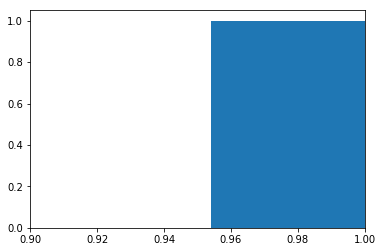

mean AUC: 0.942660612268
median: 0.942660612268
stddev: 0.0


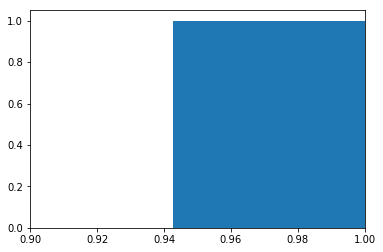

mean AUC: 0.958222970958
median: 0.958222970958
stddev: 0.0


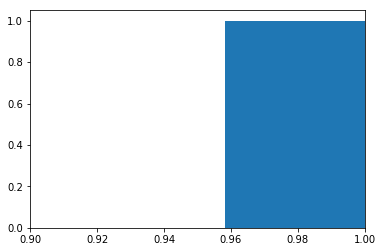

mean AUC: 0.962123537351
median: 0.962123537351
stddev: 0.0


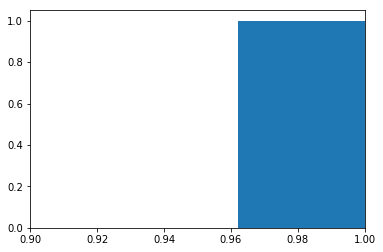

{'aucs': [0.96212353735131739],
 'mean': 0.96212353735131739,
 'median': 0.96212353735131739,
 'std': 0.0}

In [7]:
model_bias_analysis.plot_model_family_auc(madlibs,['wiki_cnn_v3_102'], 'label')
model_bias_analysis.plot_model_family_auc(madlibs,['wiki_debias_random_cnn_v3_102'], 'label')

model_bias_analysis.plot_model_family_auc(madlibs,['cnn_attention_wiki_tox_v2_102'], 'label')

model_bias_analysis.plot_model_family_auc(madlibs,['cnn_attention_debias_tox_v2_102'], 'label')


original models:
mean AUC: 0.947379170387
median: 0.951928121617
stddev: 0.0120294175574


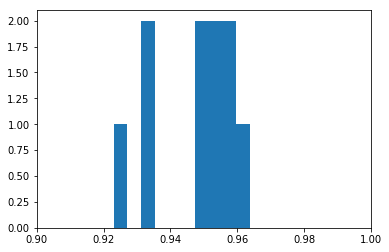



random models:
mean AUC: 0.953322001581
median: 0.953108470234
stddev: 0.00926717266027


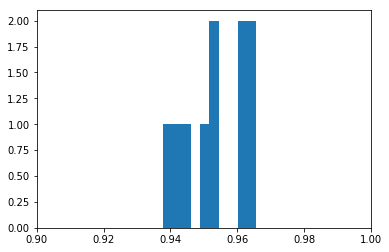



debias models:
mean AUC: 0.960802586633
median: 0.960868362472
stddev: 0.00621414963187


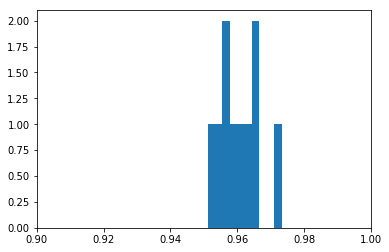



attention models:
mean AUC: 0.953006052479
median: 0.958610252457
stddev: 0.0128187385725


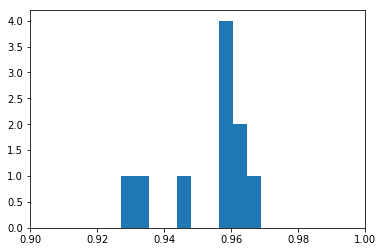

{'aucs': [0.96111104855426566,
  0.95899753395593212,
  0.95822297095768172,
  0.94496557333110398,
  0.92701373326082415,
  0.95649811724032541,
  0.95907261797826704,
  0.96192730450340702,
  0.96899321994004317,
  0.93325840507003743],
 'mean': 0.95300605247918857,
 'median': 0.95861025245680698,
 'std': 0.012818738572505196}

In [8]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label')
print('\n\nattention models:')
model_bias_analysis.plot_model_family_auc(madlibs, attention_model_names, 'label')

In [9]:
print(madlibs.columns)

Index([u'Unnamed: 0', u'text', u'Template', u'label', u'wiki_cnn_v3_100',
       u'wiki_cnn_v3_101', u'wiki_cnn_v3_102', u'wiki_cnn_v3_103',
       u'wiki_cnn_v3_104', u'wiki_cnn_v3_105', u'wiki_cnn_v3_106',
       u'wiki_cnn_v3_107', u'wiki_cnn_v3_108', u'wiki_cnn_v3_109',
       u'wiki_debias_random_cnn_v3_100', u'wiki_debias_random_cnn_v3_101',
       u'wiki_debias_random_cnn_v3_102', u'wiki_debias_random_cnn_v3_103',
       u'wiki_debias_random_cnn_v3_104', u'wiki_debias_random_cnn_v3_105',
       u'wiki_debias_random_cnn_v3_106', u'wiki_debias_random_cnn_v3_107',
       u'wiki_debias_random_cnn_v3_108', u'wiki_debias_random_cnn_v3_109',
       u'wiki_debias_cnn_v3_100', u'wiki_debias_cnn_v3_101',
       u'wiki_debias_cnn_v3_102', u'wiki_debias_cnn_v3_103',
       u'wiki_debias_cnn_v3_104', u'wiki_debias_cnn_v3_105',
       u'wiki_debias_cnn_v3_106', u'wiki_debias_cnn_v3_107',
       u'wiki_debias_cnn_v3_108', u'wiki_debias_cnn_v3_109',
       u'cnn_attention_wiki_tox_v2_100', u'cn

## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [10]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [11]:
madlibs_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')

In [12]:
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'text', madlibs_terms)

In [13]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_subgroup_aucs(madlibs, madlibs_terms, all_model_families_names, 'label')

CPU times: user 2.69 s, sys: 20 ms, total: 2.71 s
Wall time: 2.72 s


In [14]:
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'text', madlibs_terms)


In [15]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_subgroup_aucs(madlibs, madlibs_terms, all_model_families_names, 'label')

CPU times: user 2.7 s, sys: 4 ms, total: 2.71 s
Wall time: 2.71 s


In [16]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
_term_madlibs_aucs[['subgroup', 'orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

,subgroup,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.892670,0.042194,0.890695,0.026493,0.930178,0.015959
2,bisexual,0.928644,0.031313,0.940483,0.016706,0.959942,0.010005
1,gay,0.931674,0.019837,0.937047,0.012426,0.959577,0.009101
0,lesbian,0.934130,0.023957,0.944190,0.011090,0.959474,0.009110
8,homosexual,0.938732,0.022471,0.945094,0.016736,0.964736,0.006794
28,middle eastern,0.940379,0.015527,0.947799,0.007464,0.953885,0.016507
3,transgender,0.940618,0.027660,0.950455,0.013958,0.963843,0.007808
30,japanese,0.942513,0.009240,0.948450,0.008735,0.956400,0.008723
24,canadian,0.946667,0.010836,0.955395,0.009844,0.956539,0.004074
18,european,0.947188,0.011229,0.956887,0.008972,0.961798,0.006711


per-term AUC histogram: mean AUCs across terms for: orig_mean


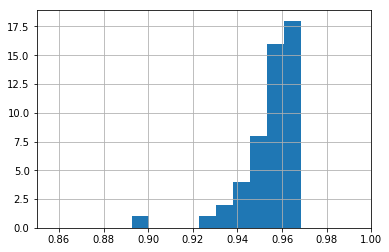

per-term AUC histogram: mean AUCs across terms for: random_mean


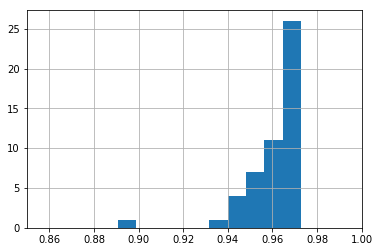

per-term AUC histogram: mean AUCs across terms for: debias_mean


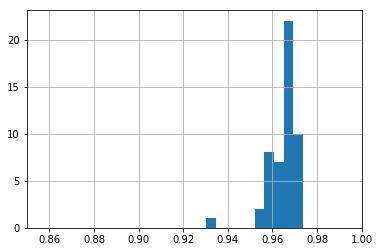

In [17]:
for mean_col in ['orig_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

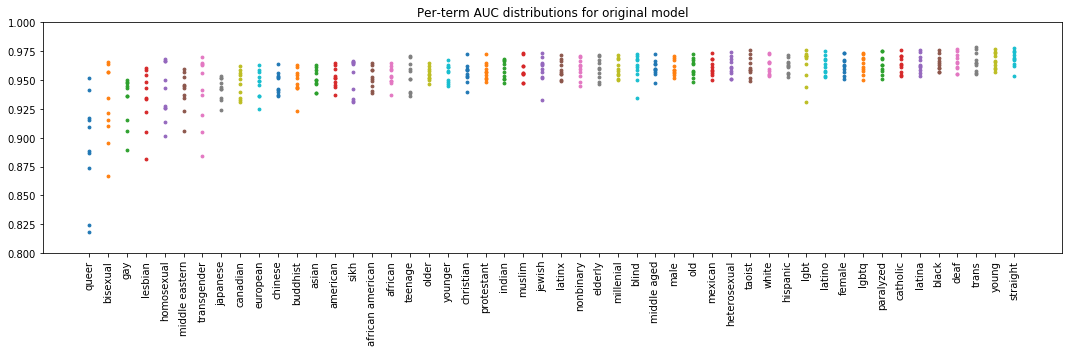

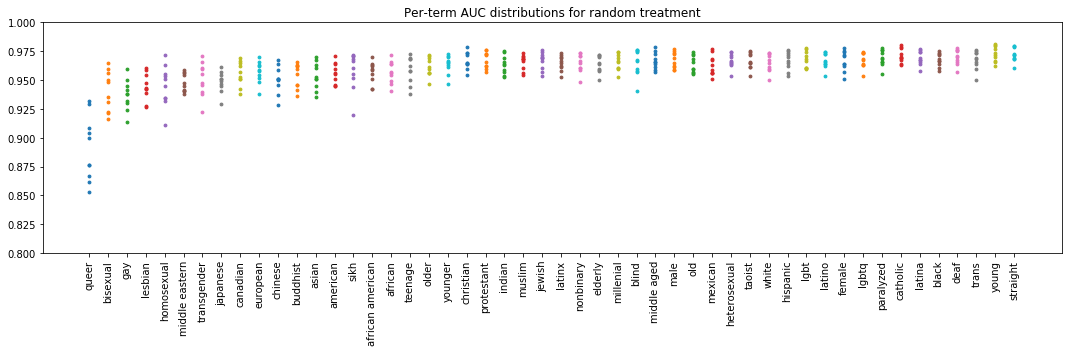

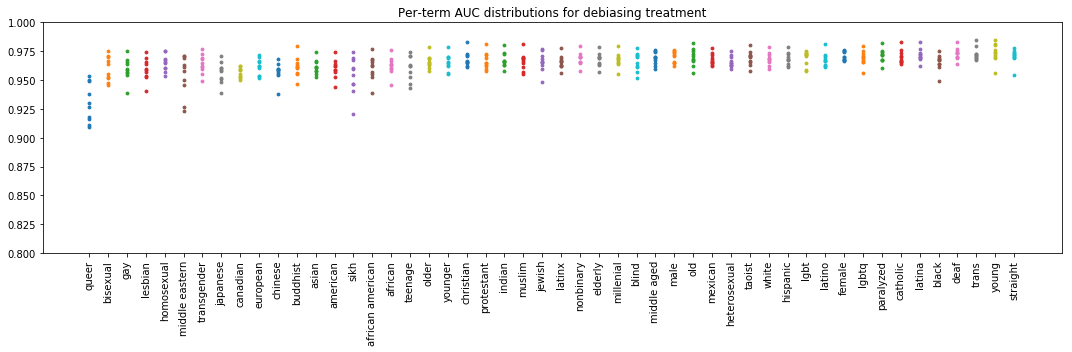

In [18]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_madlibs_aucs, 'subgroup', auc_collection_col, title='Per-term AUC distributions for ' + title,
        file_name='madlibs')

### Per-term  AUCs on the wikipedia dataset

In [19]:
%%time
model_bias_analysis.add_subgroup_columns_from_text(wiki_test, 'text', madlibs_terms)


CPU times: user 8.76 s, sys: 144 ms, total: 8.91 s
Wall time: 8.79 s


In [20]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_subgroup_aucs(wiki_test, madlibs_terms, all_model_families_names, 'label')

/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.31 s


In [21]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')


We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

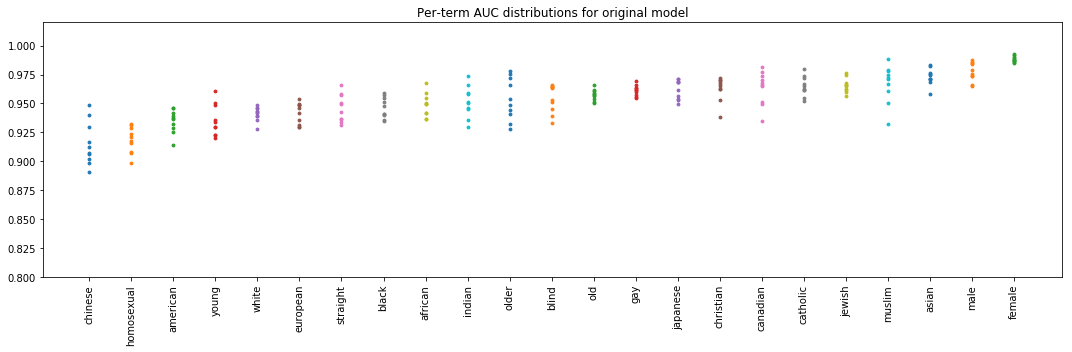

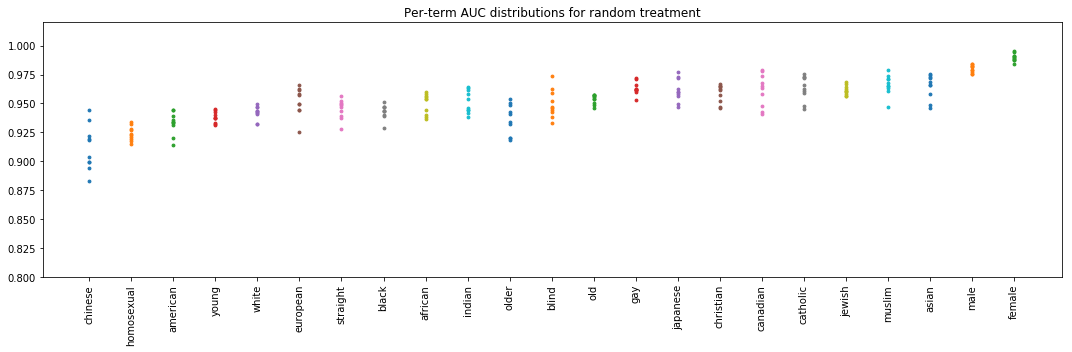

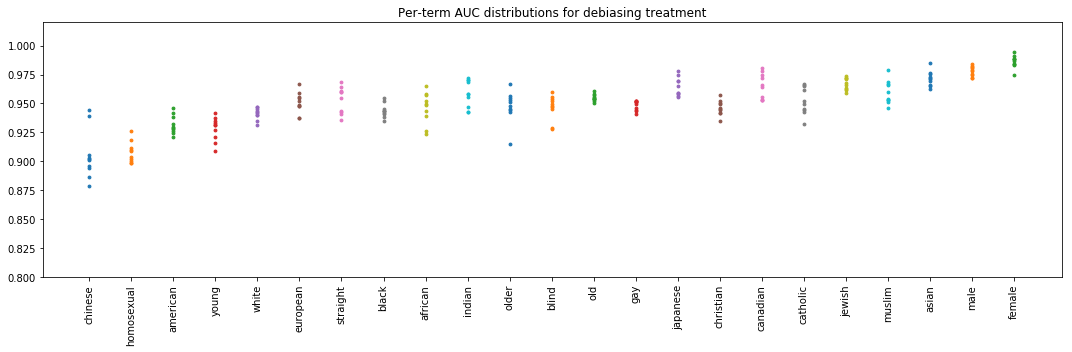

In [22]:

# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(_term_wiki_aucs_nottiny, 'subgroup', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02),
                                              file_name='wiki')


## Qualitative look

In [23]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.019  (std: 0.0257)  i am a music person
0.024  (std: 0.0413)  i am a box person
0.057  (std: 0.0457)  i am a teacher person
0.088  (std: 0.0709)  i am a christian person
0.104  (std: 0.1219)  i am a wikipedia person
0.120  (std: 0.0999)  i am a straight person
0.142  (std: 0.0663)  i am a heterosexual person
0.166  (std: 0.1482)  i am a muslim person
0.172  (std: 0.0706)  i am a white person
0.186  (std: 0.1781)  i am a jewish person
0.197  (std: 0.0945)  i am a tall person
0.200  (std: 0.1756)  i am a feminist person
0.384  (std: 0.1356)  i am a black person
0.703  (std: 0.1992)  i am a transgender person
0.747  (std: 0.1936)  i am a lesbian person
0.757  (std: 0.1478)  i am a gay person
0.762  (std: 0.1951)  i am a homosexual person
0.815  (std: 0.1985)  i am a bisexual person
0.860  (std: 0.0677)  i am a jew person
0.884  (std: 0.0822)  i am a queer person


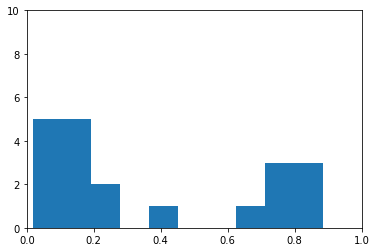

In [24]:
_print_template_scores(wiki_models)

0.021  (std: 0.0086)  i am a music person
0.027  (std: 0.0327)  i am a box person
0.057  (std: 0.0461)  i am a teacher person
0.077  (std: 0.0794)  i am a wikipedia person
0.084  (std: 0.0777)  i am a heterosexual person
0.107  (std: 0.0840)  i am a straight person
0.119  (std: 0.0556)  i am a white person
0.121  (std: 0.1027)  i am a christian person
0.160  (std: 0.1158)  i am a muslim person
0.167  (std: 0.1335)  i am a tall person
0.195  (std: 0.1459)  i am a jewish person
0.223  (std: 0.0709)  i am a feminist person
0.311  (std: 0.0950)  i am a black person
0.594  (std: 0.1650)  i am a lesbian person
0.601  (std: 0.2042)  i am a homosexual person
0.629  (std: 0.1819)  i am a transgender person
0.665  (std: 0.1689)  i am a gay person
0.710  (std: 0.1671)  i am a bisexual person
0.827  (std: 0.1014)  i am a jew person
0.851  (std: 0.0584)  i am a queer person


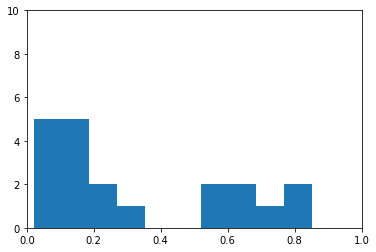

In [25]:
_print_template_scores(random_models)

0.019  (std: 0.0195)  i am a music person
0.035  (std: 0.0185)  i am a box person
0.056  (std: 0.0266)  i am a teacher person
0.077  (std: 0.0681)  i am a straight person
0.088  (std: 0.0670)  i am a christian person
0.094  (std: 0.1014)  i am a feminist person
0.100  (std: 0.0972)  i am a wikipedia person
0.118  (std: 0.0754)  i am a white person
0.119  (std: 0.0712)  i am a heterosexual person
0.160  (std: 0.0787)  i am a tall person
0.189  (std: 0.1284)  i am a transgender person
0.196  (std: 0.1101)  i am a muslim person
0.218  (std: 0.0569)  i am a jewish person
0.241  (std: 0.1042)  i am a gay person
0.244  (std: 0.0976)  i am a lesbian person
0.318  (std: 0.1511)  i am a black person
0.342  (std: 0.1126)  i am a bisexual person
0.364  (std: 0.1351)  i am a homosexual person
0.696  (std: 0.1353)  i am a queer person
0.805  (std: 0.0989)  i am a jew person


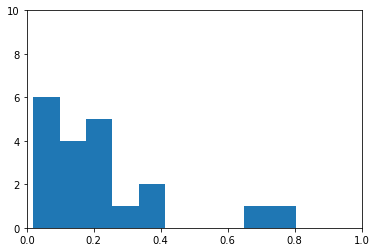

In [26]:
_print_template_scores(debias_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [27]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_fnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [28]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_subgroup_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'label')

CPU times: user 8.84 s, sys: 0 ns, total: 8.84 s
Wall time: 8.84 s


In [29]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [30]:
neg_table_means(_term_neg_rates_50)


,subgroup,orig_fnr_mean,random_fnr_mean,debias_fnr_mean,orig_tnr_mean,random_tnr_mean,debias_tnr_mean
5,queer,0.000000,0.000000,0.000661,0.042008,0.029326,0.143989
1,gay,0.000661,0.001321,0.018098,0.160766,0.243593,0.543065
8,homosexual,0.000925,0.000925,0.009511,0.234082,0.276618,0.499472
2,bisexual,0.001057,0.000793,0.013606,0.187054,0.204624,0.456803
0,lesbian,0.001717,0.001321,0.030251,0.198283,0.293395,0.575561
3,transgender,0.001849,0.002378,0.021797,0.246367,0.333421,0.536328
37,sikh,0.005680,0.008190,0.012285,0.364069,0.433950,0.365522
43,teenage,0.006605,0.010172,0.013606,0.448481,0.521136,0.479524
47,blind,0.008587,0.011625,0.006737,0.566843,0.654557,0.517041
6,lgbt,0.012021,0.015059,0.071202,0.611493,0.666711,0.885469


In [31]:
neg_table_stddevs(_term_neg_rates_50)

,subgroup,orig_tnr_std,random_tnr_std,debias_tnr_std,orig_tnr_std,random_tnr_std,debias_tnr_std
5,queer,0.051779,0.038171,0.095616,0.051779,0.038171,0.095616
1,gay,0.101918,0.176520,0.221290,0.101918,0.176520,0.221290
8,homosexual,0.174337,0.212668,0.147287,0.174337,0.212668,0.147287
2,bisexual,0.128894,0.156875,0.204409,0.128894,0.156875,0.204409
0,lesbian,0.130267,0.177127,0.235893,0.130267,0.177127,0.235893
3,transgender,0.159502,0.189124,0.217595,0.159502,0.189124,0.217595
37,sikh,0.152978,0.204376,0.269680,0.152978,0.204376,0.269680
43,teenage,0.193909,0.209671,0.210735,0.193909,0.209671,0.210735
47,blind,0.139847,0.162415,0.151262,0.139847,0.162415,0.151262
6,lgbt,0.174900,0.172262,0.116187,0.174900,0.172262,0.116187


### Threshold using per-model equal error rate on overall madlibs dataset

In [32]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

CPU times: user 1min 8s, sys: 4 ms, total: 1min 8s
Wall time: 1min 8s


In [33]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'label')

CPU times: user 9.02 s, sys: 8 ms, total: 9.03 s
Wall time: 9.03 s


In [34]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

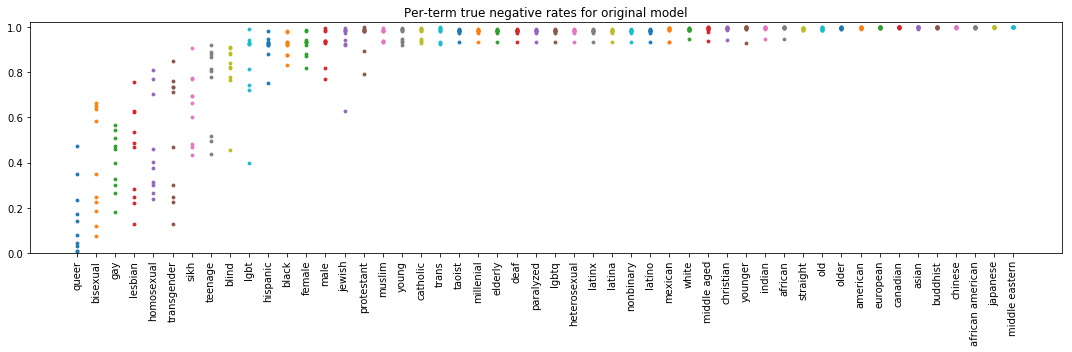

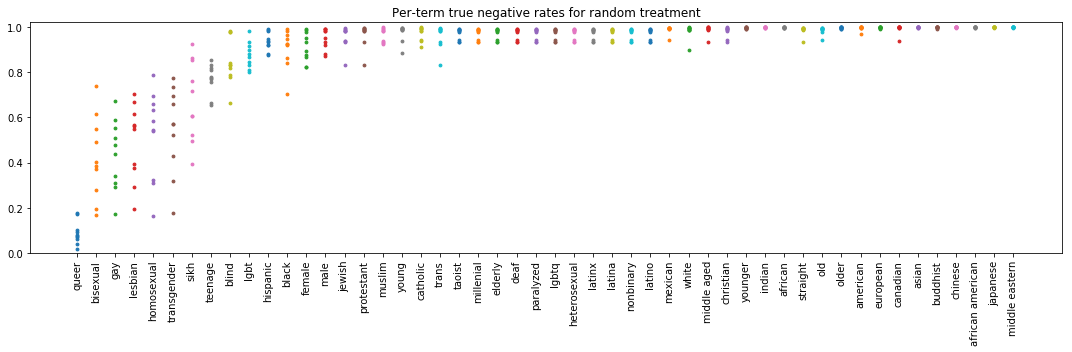

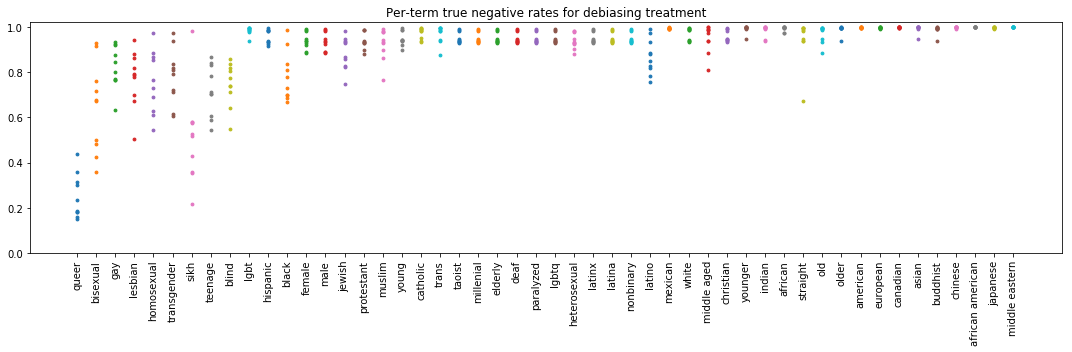

In [35]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='madlibs')

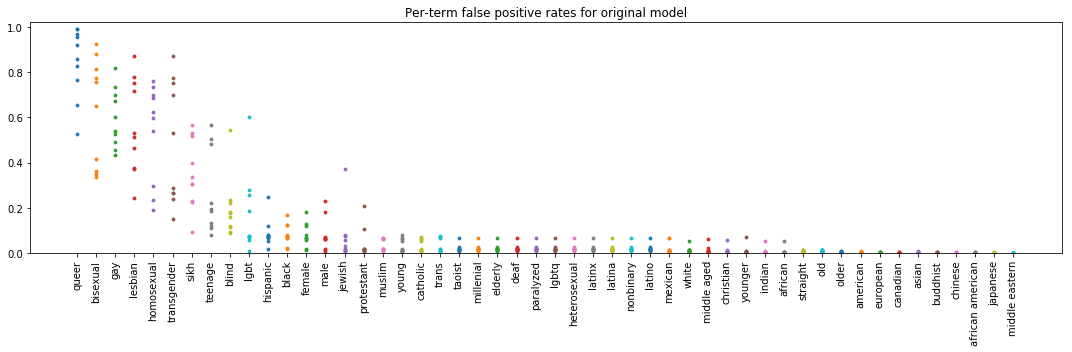

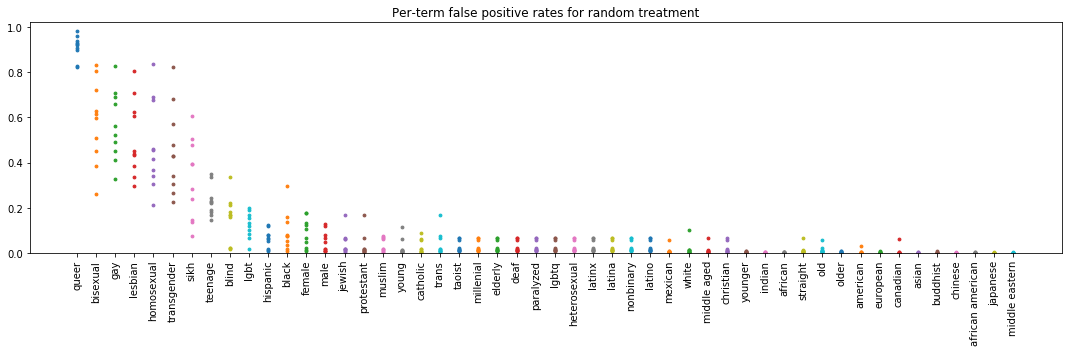

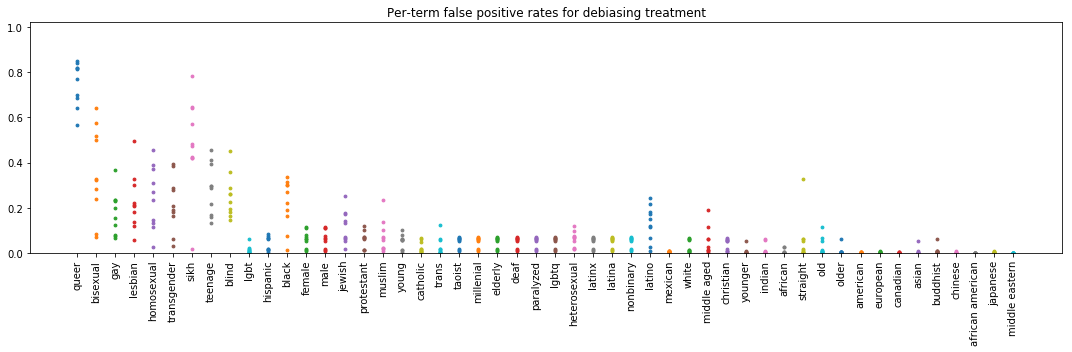

In [36]:
# False positive rates: 1 - TNR. This is just the above graphs except flipped to show false positives instead of true negatives.

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    term_fpr_values = []
    for _i, row in _term_neg_rates_madlibs_eer_tnr_sorted.iterrows():
        tnr_values = row[tnr_values_col]
        fpr_values = [1 - tnr for tnr in tnr_values]
        term_fpr_values.append({'subgroup': row['subgroup'], 'fpr_values': fpr_values})
    fpr_df = pd.DataFrame(term_fpr_values)
    model_bias_analysis.per_subgroup_scatterplots(
        fpr_df, 'subgroup', 'fpr_values', y_lim=(0, 1.02),
        title='Per-term false positive rates for ' + title,
        file_name='madlibs_' + tnr_values_col)

### Threshold using per-model equal error rate on Wikipedia test set

The EERs computed on the wikipedia test set are similar, and so we don't see much difference in the per-term negative rates plots.

In [37]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

CPU times: user 20.8 s, sys: 0 ns, total: 20.8 s
Wall time: 20.8 s


In [40]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

CPU times: user 8.66 s, sys: 0 ns, total: 8.66 s
Wall time: 8.66 s


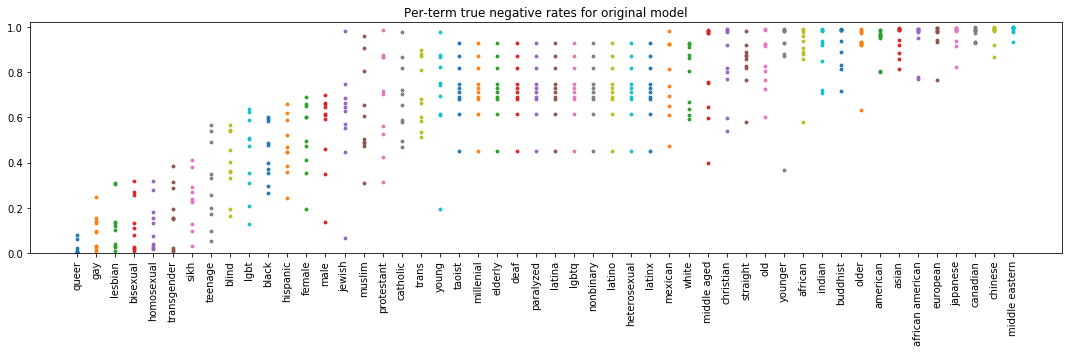

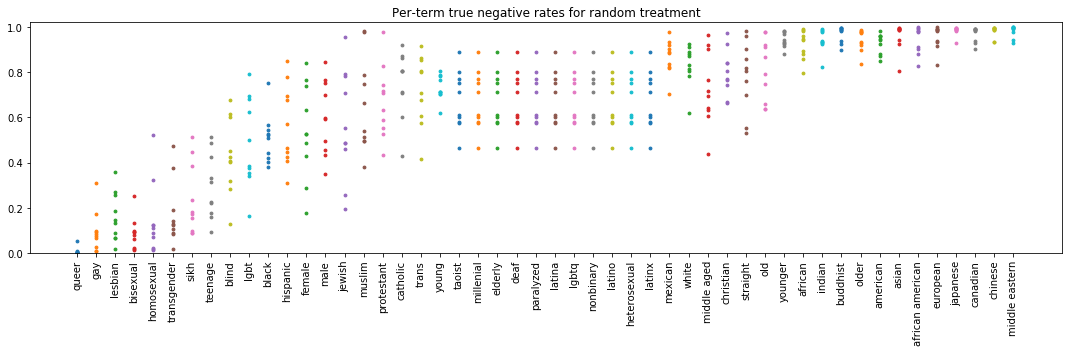

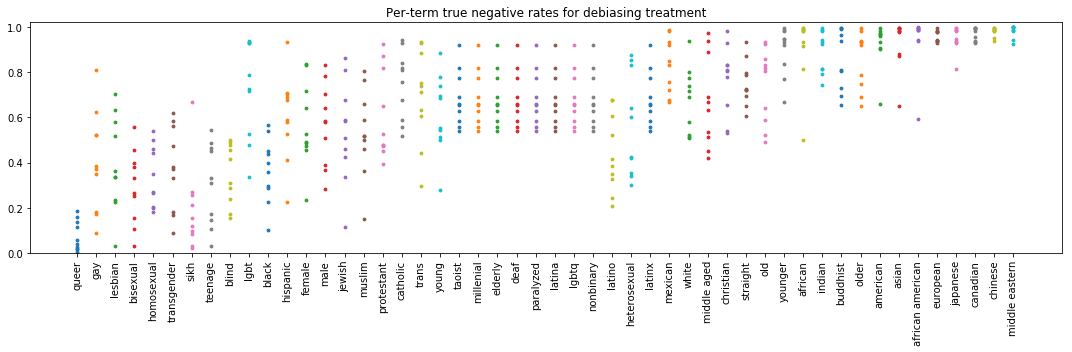

In [44]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='wiki')

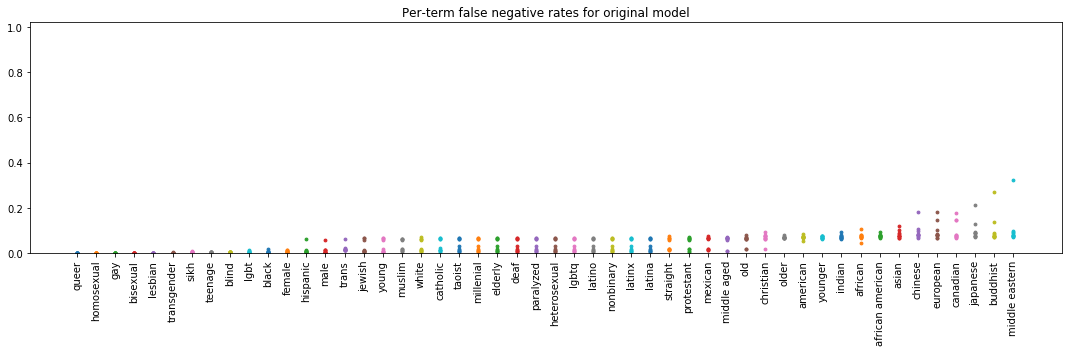

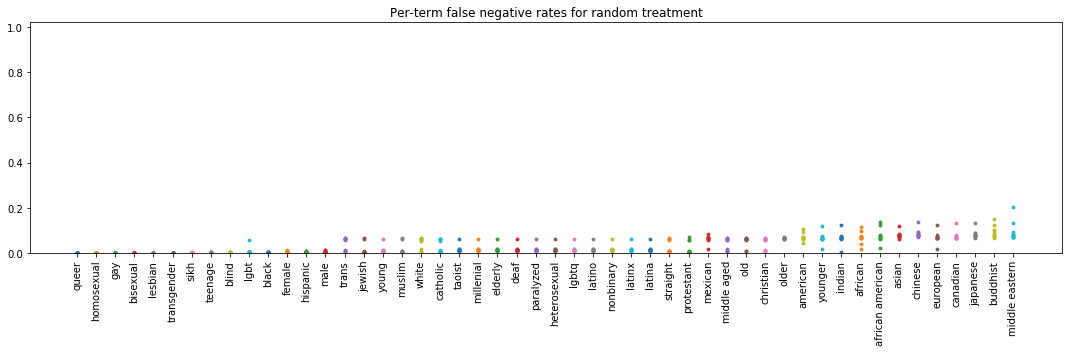

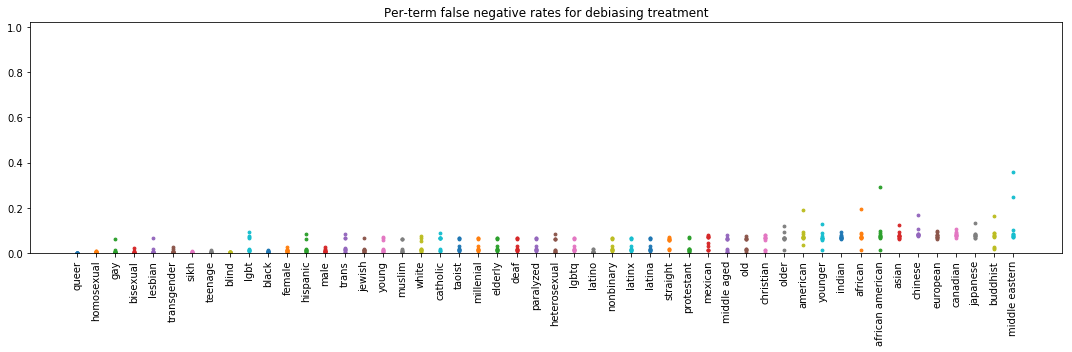

In [45]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'subgroup', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title, file_name='wiki')

In [48]:
model_bias_analysis.per_subgroup_fnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)


{'cnn_attention_debias_tox_v2_10': 17.754507552483535,
 'cnn_attention_wiki_tox_v2_10': 33.250648614257116,
 'wiki_cnn_v3_10': 33.04522124866725,
 'wiki_debias_cnn_v3_10': 21.886600909319473,
 'wiki_debias_random_cnn_v3_10': 34.47019128090454}

In [51]:
model_bias_analysis.per_subgroup_tnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'cnn_attention_debias_tox_v2_10': 46.471050682286354,
 'cnn_attention_wiki_tox_v2_10': 74.21380305246399,
 'wiki_cnn_v3_10': 73.60468036790454,
 'wiki_debias_cnn_v3_10': 50.54720430743497,
 'wiki_debias_random_cnn_v3_10': 68.16544596358099}

In [52]:
model_bias_analysis.per_subgroup_auc_diff_from_overall(madlibs, madlibs_terms, all_model_families_names)

{'cnn_attention_debias_tox_v2_10': 3.2458717384980438,
 'cnn_attention_wiki_tox_v2_10': 6.5681390766975412,
 'wiki_cnn_v3_10': 6.6255057108568094,
 'wiki_debias_cnn_v3_10': 3.7319119872484894,
 'wiki_debias_random_cnn_v3_10': 6.0888269607290981}